Import

In [10]:
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import matplotlib.pyplot as plt
import numpy as np
import tarfile
import os

from timeit import default_timer as timer
from tqdm.auto import tqdm
from torchvision import datasets, models, transforms
from torchsummary import summary
from typing import Callable, Dict, List, Tuple, Union
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter

Riproducibilità

In [11]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=7)

Setting GPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# The rest of your code using the device

Device: cpu


Montare Drive

In [4]:
"""from google.colab import drive
drive.mount('/content/drive')"""

"from google.colab import drive\ndrive.mount('/content/drive')"

Dataset

In [12]:
path_ds = 'archive'
path_ds_train = os.path.join(path_ds, 'train')
path_ds_val = os.path.join(path_ds, 'valid')

mean_image_net = [0.485, 0.456, 0.406]
std_image_net = [0.229, 0.224, 0.225]

normalize = transforms.Normalize(mean_image_net, std_image_net)

size_image = 224  # try 64 or 128 (only with CNN)
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(size_image),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                normalize]),

                   'val': transforms.Compose([transforms.Resize(int(size_image*1.2)),
                                              transforms.CenterCrop(size_image),
                                              transforms.ToTensor(),
                                              normalize])}

data_train = torchvision.datasets.ImageFolder(path_ds_train, data_transforms['train'])
data_val = torchvision.datasets.ImageFolder(path_ds_val, data_transforms['val'])

classes = data_train.classes
num_classes = len(classes)

Show some examples

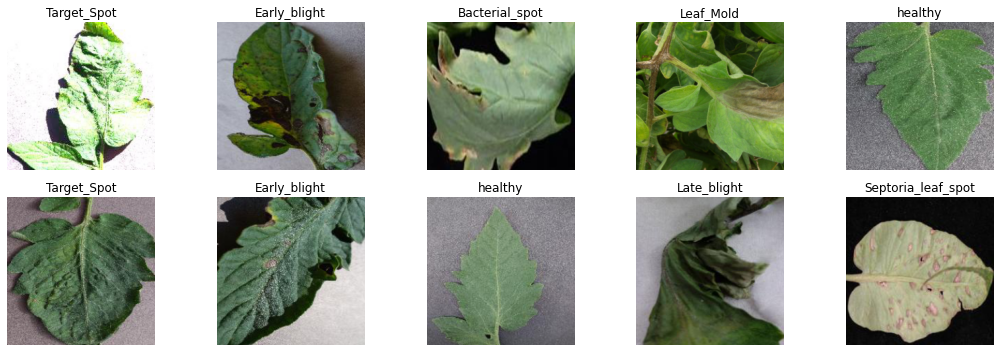

In [5]:
class NormalizeInverse(torchvision.transforms.Normalize):
    def __init__(self, mean: List[float], std: List[float]) -> None:
        """Reconstructs the images in the input domain by inverting
        the normalization transformation.

        Args:
            mean: the mean used to normalize the images.
            std: the standard deviation used to normalize the images.
        """
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

def show_grid(dataset: torchvision.datasets.ImageFolder,
              process: Callable = None) -> None:
    """Shows a grid with random images taken from the dataset.

    Args:
        dataset: the dataset containing the images.
        process: a function to apply on the images before showing them.
    """
    fig = plt.figure(figsize=(15, 5))
    indices_random = np.random.randint(10, size=10, high=len(dataset))

    for count, idx in enumerate(indices_random):
        fig.add_subplot(2, 5, count + 1)
        title = dataset.classes[dataset[idx][1]]
        plt.title(title)
        image_processed = process(dataset[idx][0]) if process is not None else dataset[idx][0]
        plt.imshow(transforms.ToPILImage()(image_processed))
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Show some examples
denormalize = NormalizeInverse(mean_image_net, std_image_net)
show_grid(data_val, process=denormalize)

Distribution

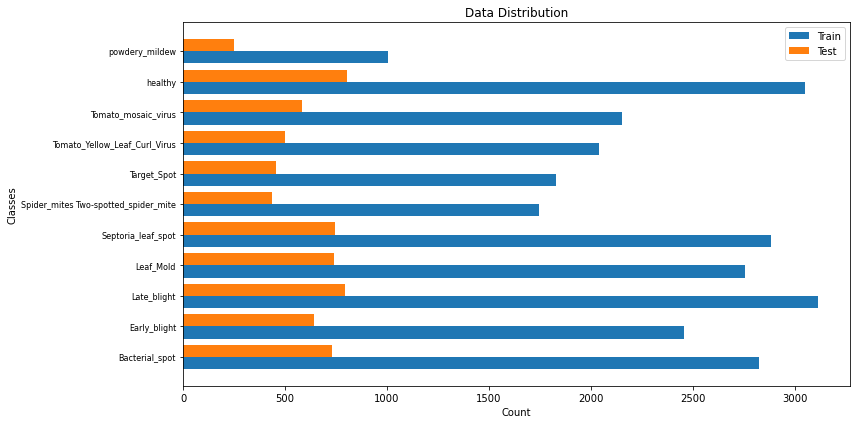

In [6]:
def plot_histograms(dataset_train: torchvision.datasets.ImageFolder,
                    dataset_test: torchvision.datasets.ImageFolder,
                    title: str,
                    classes_as_ticks: bool = True) -> None:
    """Plot histograms with train and test or validation data distributions.

    Args:
        dataset_train: the train dataset.
        dataset_test: the test or validation dataset.
        title: the title of the plot.
        classes_as_ticks: if true the name of the classes are shown on the x-axis.
    """
    classes = len(dataset_train.classes)
    bins = np.linspace(0, classes, classes + 1, dtype=int)
    plt.figure(figsize=(12, 6))  # Increase the figure size to make space for the labels
    plt.title(title)

    # Compute histogram data
    train_hist, train_bins = np.histogram(dataset_train.targets, bins=bins)
    test_hist, test_bins = np.histogram(dataset_test.targets, bins=bins)

    # Calculate bar width
    bar_width = 0.4

    # Positions for the bars
    r1 = np.arange(len(train_hist))
    r2 = [x + bar_width for x in r1]

    # Draw the bars
    plt.barh(r1, train_hist, height=bar_width, align='center', label='Train')
    plt.barh(r2, test_hist, height=bar_width, align='center', label='Test')

    # Set ticks and labels
    plt.yticks(r1 + bar_width / 2, dataset_train.classes, fontsize=8)
    plt.xlabel('Count')
    plt.ylabel('Classes')

    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

plot_histograms(data_train, data_val, "Data Distribution")



Data Loaders

In [7]:
num_workers = 2
size_batch = 64

loader_train = torch.utils.data.DataLoader(data_train, batch_size=size_batch,
                                           shuffle=True,
                                           pin_memory=True, # speed-up CPU-GPU transfer
                                           num_workers=num_workers)

loader_val = torch.utils.data.DataLoader(data_val, batch_size=size_batch,
                                         shuffle=False,
                                         num_workers=num_workers)

Training functions

In [13]:
# Accuracy
def get_correct_samples(scores: torch.Tensor, labels: torch.Tensor) -> int:
    """Gets the number of correctly classified examples.

    Args:
        scores: the scores predicted with the network.
        labels: the class labels.

    Returns:
        the number of correct samples.
    """
    classes_predicted = torch.argmax(scores, 1)
    return (classes_predicted == labels).sum().item()

# Train one epoch
def train(writer: utils.tensorboard.writer.SummaryWriter,
          model: nn.Module,
          train_loader: utils.data.DataLoader,
          device: torch.device,
          optimizer: torch.optim,
          criterion: Callable[[torch.Tensor, torch.Tensor], float],
          log_interval: int,
          epoch: int) -> Tuple[float, float]:
    """Trains a neural network for one epoch.

    Args:
        model: the model to train.
        train_loader: the data loader containing the training data.
        device: the device to use to train the model.
        optimizer: the optimizer to use to train the model.
        criterion: the loss to optimize.
        log_interval: the log interval.
        epoch: the number of the current epoch.

    Returns:
        the cross entropy Loss value on the training data.
        the accuracy on the training data.
    """
    correct = 0
    samples_train = 0
    loss_train = 0
    size_ds_train = len(train_loader.dataset)
    num_batches = len(train_loader)

    model.train()
    for idx_batch, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        scores = model(images)

        loss = criterion(scores, labels)
        loss_train += loss.item() * len(images)
        samples_train += len(images)

        loss.backward()
        optimizer.step()
        correct += get_correct_samples(scores, labels)

        if log_interval > 0:
            if idx_batch % log_interval == 0:
                running_loss = loss_train / samples_train
                global_step = idx_batch + (epoch * num_batches)
                writer.add_scalar('Metrics/Loss_Train_IT', running_loss, global_step)
                # Visualize images on tensorboard
                indices_random = torch.randperm(images.size(0))[:4]
                writer.add_images('Samples/Train', denormalize(images[indices_random]), global_step)

    loss_train /= samples_train
    accuracy_training = 100. * correct / samples_train
    return loss_train, accuracy_training

# Validate one epoch
def validate(model: nn.Module,
             data_loader: utils.data.DataLoader,
             device: torch.device,
             criterion: Callable[[torch.Tensor, torch.Tensor], float]) -> Tuple[float, float]:
    """Evaluates the model.

    Args:
        model: the model to evalaute.
        data_loader: the data loader containing the validation or test data.
        device: the device to use to evaluate the model.
        criterion: the loss function.

    Returns:
        the loss value on the validation data.
        the accuracy on the validation data.
    """
    correct = 0
    samples_val = 0
    loss_val = 0.
    model = model.eval()
    with torch.no_grad():
        for idx_batch, (images, labels) in enumerate(data_loader):
            images, labels = images.to(device), labels.to(device)
            scores = model(images)

            loss = criterion(scores, labels)
            loss_val += loss.item() * len(images)
            samples_val += len(images)
            correct += get_correct_samples(scores, labels)

    loss_val /= samples_val
    accuracy = 100. * correct / samples_val
    return loss_val, accuracy

Training Loop

In [14]:
def training_loop(writer: utils.tensorboard.writer.SummaryWriter,
                  num_epochs: int,
                  optimizer: torch.optim,
                  lr_scheduler: torch.optim.lr_scheduler,
                  log_interval: int,
                  model: nn.Module,
                  loader_train: utils.data.DataLoader,
                  loader_val: utils.data.DataLoader,
                  verbose: bool=True) -> Dict:
    """Executes the training loop.

        Args:
            writer: the summary writer for tensorboard.
            num_epochs: the number of epochs.
            optimizer: the optimizer to use.
            lr_scheduler: the scheduler for the learning rate.
            log_interval: intervall to print on tensorboard.
            model: the mode to train.
            loader_train: the data loader containing the training data.
            loader_val: the data loader containing the validation data.
            verbose: if true print the value of loss.

        Returns:
            A dictionary with the statistics computed during the train:
            the values for the train loss for each epoch.
            the values for the train accuracy for each epoch.
            the values for the validation accuracy for each epoch.
            the time of execution in seconds for the entire loop.
    """
    criterion = nn.CrossEntropyLoss()
    loop_start = timer()

    losses_values = []
    train_acc_values = []
    val_acc_values = []
    for epoch in range(1, num_epochs + 1):
        time_start = timer()
        loss_train, accuracy_train = train(writer, model, loader_train, device,
                                           optimizer, criterion, log_interval,
                                           epoch)
        loss_val, accuracy_val = validate(model, loader_val, device, criterion)
        time_end = timer()

        losses_values.append(loss_train)
        train_acc_values.append(accuracy_train)
        val_acc_values.append(accuracy_val)

        lr = optimizer.param_groups[0]['lr']

        if verbose:
            print(f'Epoch: {epoch} '
                  f' Lr: {lr:.8f} '
                  f' Loss: Train = [{loss_train:.4f}] - Val = [{loss_val:.4f}] '
                  f' Accuracy: Train = [{accuracy_train:.2f}%] - Val = [{accuracy_val:.2f}%] '
                  f' Time one epoch (s): {(time_end - time_start):.4f} ')

        # Plot to tensorboard
        writer.add_scalar('Hyperparameters/Learning Rate', lr, epoch)
        writer.add_scalars('Metrics/Losses', {"Train": loss_train, "Val": loss_val}, epoch)
        writer.add_scalars('Metrics/Accuracy', {"Train": accuracy_train, "Val": accuracy_val}, epoch)
        writer.flush()

        # Increases the internal counter
        if lr_scheduler:
            lr_scheduler.step()

    loop_end = timer()
    time_loop = loop_end - loop_start
    if verbose:
        print(f'Time for {num_epochs} epochs (s): {(time_loop):.3f}')

    return {'loss_values': losses_values,
            'train_acc_values': train_acc_values,
            'val_acc_values': val_acc_values,
            'time': time_loop}

Execute

In [15]:
def execute(name_train: str, network: nn.Module, starting_lr: float,
            num_epochs: int,
            data_loader_train: torch.utils.data.DataLoader,
            data_loader_val: torch.utils.data.DataLoader) -> None:
    """Executes the training loop.

    Args:
        name_train: the name for the log subfolder.
        network: the network to train.
        starting_lr: the staring learning rate.
        num_epochs: the number of epochs.
        data_loader_train: the data loader with training data.
        data_loader_val: the data loader with validation data.
    """
    # Visualization
    log_interval = 20
    log_dir = os.path.join("logs", name_train)
    writer = torch.utils.tensorboard.writer.SummaryWriter(log_dir)

    # Optimization
    optimizer = optim.SGD(network.parameters(), lr=starting_lr, momentum=0.9,
                          weight_decay=0.0001)

    # Learning Rate schedule: decays the learning rate by a factor of `gamma`
    # every `step_size` epochs
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    statistics = training_loop(writer, num_epochs, optimizer, scheduler,
                               log_interval, network, data_loader_train,
                               data_loader_val)
    writer.close()

    best_epoch = np.argmax(statistics['val_acc_values']) + 1
    best_accuracy = statistics['val_acc_values'][best_epoch - 1]

    print(f'Best val accuracy: {best_accuracy:.2f} epoch: {best_epoch}.')

Model function

In [16]:
def get_model(model_name: str, pretrained: bool, num_classes: int) -> nn.Module:
    """Gets an image classifier based on the specified model.

    Args:
        model_name: the name of the model, e.g., 'resnet18', 'alexnet', etc.
        pretrained: if true initializes the network with ImageNet weights.
        num_classes: the number of classes.

    Returns:
        The required network.
    """
    # Get the specified model by name
    model = getattr(models, model_name)(pretrained=pretrained)

    # Check if the model has a classifier attribute (e.g., 'fc' for ResNet) 
    if hasattr(model, 'classifier'):
        # Override the classifier with a new fully connected layer
        in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_features, num_classes)
    else:
        # If the model does not have 'classifier', it may have 'fc' attribute (e.g., for AlexNet)
        # Override the 'fc' attribute with a new fully connected layer
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)

    return model



In [13]:
def set_requires_grad_for_layer(layer: torch.nn.Module, train: bool) -> None:
    """Sets the attribute requires_grad to True or False for each parameter.
        
        Args:
            layer: the layer to freeze.
            train: if true train the layer.
    """
    for p in layer.parameters():
        p.requires_grad = train


AlexNet from Scratch

In [17]:
# Load AlexNet with random weights (pretrained=False) and set the number of classes
net_from_scratch = models.alexnet(pretrained=False, num_classes=num_classes)

# Move the model to the chosen device (e.g., GPU or CPU)
net_from_scratch.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
name_train = "alexnet_from_scratch"
lr = 0.001
num_epochs = 10  # try a higher number
execute(name_train, net_from_scratch, lr, num_epochs, loader_train, loader_val)

Epoch: 1  Lr: 0.00100000  Loss: Train = [2.3812] - Val = [2.3593]  Accuracy: Train = [11.99%] - Val = [11.58%]  Time one epoch (s): 934.6781 
Epoch: 2  Lr: 0.00100000  Loss: Train = [2.3459] - Val = [2.3131]  Accuracy: Train = [12.22%] - Val = [13.38%]  Time one epoch (s): 882.5835 
Epoch: 3  Lr: 0.00100000  Loss: Train = [2.2247] - Val = [2.0867]  Accuracy: Train = [19.63%] - Val = [23.09%]  Time one epoch (s): 921.5379 
Epoch: 4  Lr: 0.00100000  Loss: Train = [2.0245] - Val = [1.9110]  Accuracy: Train = [26.72%] - Val = [30.73%]  Time one epoch (s): 912.0543 
Epoch: 5  Lr: 0.00100000  Loss: Train = [1.8921] - Val = [1.6817]  Accuracy: Train = [31.93%] - Val = [40.89%]  Time one epoch (s): 911.9613 
Epoch: 6  Lr: 0.00010000  Loss: Train = [1.7910] - Val = [1.6352]  Accuracy: Train = [36.03%] - Val = [41.54%]  Time one epoch (s): 920.4755 
Epoch: 7  Lr: 0.00010000  Loss: Train = [1.7678] - Val = [1.6311]  Accuracy: Train = [36.83%] - Val = [41.49%]  Time one epoch (s): 925.0795 
Epoch:

Resnet Fine Tuned

In [14]:
net_feat_ext = get_model('resnet18',True, num_classes)
net_feat_ext.to(device)
# print(net_feat_ext)

set_requires_grad_for_layer(net_feat_ext.conv1, False)
set_requires_grad_for_layer(net_feat_ext.bn1, False)
set_requires_grad_for_layer(net_feat_ext.layer1, False)
set_requires_grad_for_layer(net_feat_ext.layer2, False)
set_requires_grad_for_layer(net_feat_ext.layer3, False)
set_requires_grad_for_layer(net_feat_ext.layer4, False)

summary(net_feat_ext, input_size=(3, size_image, size_image))

/usr/local/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/akirapetrolini/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [15]:
name_train = "resnet_feat_ext"
lr = 0.001
num_epochs = 10  # try a higher number
execute(name_train, net_feat_ext, lr, num_epochs, loader_train, loader_val)

Epoch: 1  Lr: 0.00100000  Loss: Train = [1.4828] - Val = [0.9530]  Accuracy: Train = [54.70%] - Val = [73.40%]  Time one epoch (s): 1348.1833 
Epoch: 2  Lr: 0.00100000  Loss: Train = [1.0283] - Val = [0.7729]  Accuracy: Train = [68.74%] - Val = [77.85%]  Time one epoch (s): 1397.9713 
Epoch: 3  Lr: 0.00100000  Loss: Train = [0.9202] - Val = [0.7196]  Accuracy: Train = [71.25%] - Val = [78.20%]  Time one epoch (s): 1467.4021 
Epoch: 4  Lr: 0.00100000  Loss: Train = [0.8698] - Val = [0.6610]  Accuracy: Train = [72.51%] - Val = [80.05%]  Time one epoch (s): 1399.2310 
Epoch: 5  Lr: 0.00100000  Loss: Train = [0.8355] - Val = [0.6415]  Accuracy: Train = [73.03%] - Val = [80.08%]  Time one epoch (s): 1552.3013 
Epoch: 6  Lr: 0.00010000  Loss: Train = [0.8125] - Val = [0.6376]  Accuracy: Train = [74.07%] - Val = [80.43%]  Time one epoch (s): 1428.8454 
Epoch: 7  Lr: 0.00010000  Loss: Train = [0.8110] - Val = [0.6326]  Accuracy: Train = [74.02%] - Val = [80.62%]  Time one epoch (s): 1413.5277 

AlexNet Fine Tuned

In [23]:
net_feat_ext = get_model('alexnet',True, num_classes)
net_feat_ext.to(device)

/usr/local/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [27]:
# Freeze the lower layers (convolutional layers)
set_requires_grad_for_layer(net_feat_ext.features, False)

summary(net_feat_ext, input_size=(3, size_image, size_image))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [28]:
name_train = "alexnet_feat_ext"
lr = 0.001
num_epochs = 10  # try a higher number
execute(name_train, net_feat_ext, lr, num_epochs, loader_train, loader_val)

Epoch: 1  Lr: 0.00100000  Loss: Train = [1.1037] - Val = [0.5417]  Accuracy: Train = [61.74%] - Val = [81.64%]  Time one epoch (s): 871.6888 
Epoch: 2  Lr: 0.00100000  Loss: Train = [0.8033] - Val = [0.4146]  Accuracy: Train = [72.26%] - Val = [85.92%]  Time one epoch (s): 863.1166 
Epoch: 3  Lr: 0.00100000  Loss: Train = [0.7162] - Val = [0.3629]  Accuracy: Train = [75.41%] - Val = [87.75%]  Time one epoch (s): 879.3935 
Epoch: 4  Lr: 0.00100000  Loss: Train = [0.6700] - Val = [0.3571]  Accuracy: Train = [76.84%] - Val = [87.72%]  Time one epoch (s): 612.5308 
Epoch: 5  Lr: 0.00100000  Loss: Train = [0.6352] - Val = [0.3121]  Accuracy: Train = [77.97%] - Val = [89.21%]  Time one epoch (s): 520.9809 
Epoch: 6  Lr: 0.00010000  Loss: Train = [0.5916] - Val = [0.2889]  Accuracy: Train = [79.59%] - Val = [90.63%]  Time one epoch (s): 520.2852 
Epoch: 7  Lr: 0.00010000  Loss: Train = [0.5696] - Val = [0.2849]  Accuracy: Train = [80.56%] - Val = [90.45%]  Time one epoch (s): 526.6289 
Epoch:

Random model

In [14]:
# Get MobileNetV3 model
net_feat_ext = get_model('mobilenet_v3_large', True, num_classes)
net_feat_ext.to(device)

# Freeze the lower layers (convolutional layers)
set_requires_grad_for_layer(net_feat_ext.features, False)

# Print model summary
summary(net_feat_ext, input_size=(3, size_image, size_image))

/usr/local/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /Users/akirapetrolini/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           1,024
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]             576
      BatchNorm2d-14           [-1, 64,

In [15]:
# Training configuration
name_train = "mobilenetv3_feat_ext"
lr = 0.001
num_epochs = 10
execute(name_train, net_feat_ext, lr, num_epochs, loader_train, loader_val)

Epoch: 1  Lr: 0.00100000  Loss: Train = [1.4207] - Val = [0.7801]  Accuracy: Train = [58.75%] - Val = [77.51%]  Time one epoch (s): 896.0924 
Epoch: 2  Lr: 0.00100000  Loss: Train = [0.9271] - Val = [0.6131]  Accuracy: Train = [71.91%] - Val = [81.06%]  Time one epoch (s): 976.3503 
Epoch: 3  Lr: 0.00100000  Loss: Train = [0.8142] - Val = [0.5444]  Accuracy: Train = [74.10%] - Val = [82.45%]  Time one epoch (s): 979.1735 
Epoch: 4  Lr: 0.00100000  Loss: Train = [0.7598] - Val = [0.5076]  Accuracy: Train = [75.68%] - Val = [83.65%]  Time one epoch (s): 1070.1645 
Epoch: 5  Lr: 0.00100000  Loss: Train = [0.7213] - Val = [0.4704]  Accuracy: Train = [76.56%] - Val = [84.63%]  Time one epoch (s): 1075.1139 
Epoch: 6  Lr: 0.00010000  Loss: Train = [0.7083] - Val = [0.4668]  Accuracy: Train = [76.71%] - Val = [84.74%]  Time one epoch (s): 1034.1286 
Epoch: 7  Lr: 0.00010000  Loss: Train = [0.7035] - Val = [0.4648]  Accuracy: Train = [76.98%] - Val = [84.77%]  Time one epoch (s): 1180.4169 
Ep